# Case Study Logging Practices and Water Quality
This notebook is based on textbook [Statistical Sleuth](https://www.amazon.com/Statistical-Sleuth-Course-Methods-Analysis/dp/1133490670/ref=sr_1_1?crid=X1BDAP79JMTV&keywords=statistical+sleuth+3rd+edition&qid=1558765284&s=gateway&sprefix=statistical+sleu%2Caps%2C202&sr=8-1) covering an observational study - __Logging PRactices and Water Quality__


### Autocorrelation 
Essentially we are assess the coeffiecnt of correlation between 2 values in a time serires. to perform this we will ustilize `statmodels` function `ARF` which for our time serires $y_t$ is given by $\begin{equation*}   \mbox{Corr}(y_{t},y_{t-k}). \end{equation*}$

Where: 
* k is the time gap being considered
* lag of 1, where k = 1, is the autocorelation order between values that are k time periods apart

In [1]:
import pandas as pd
import numpy as np

# import plotting libraries
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-white')

# Statistical Packages
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [9]:
df = pd.read_csv("./data/case1501.csv")
df.head()

,Week,Patch,NoCut
0,1,0.7,0.7
1,4,0.0,0.0
2,7,0.0,0.0
3,10,2.2,0.0
4,13,1.1,0.7


In [7]:
df = df.set_index(df.Week)

/home/redne/anaconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/redne/anaconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


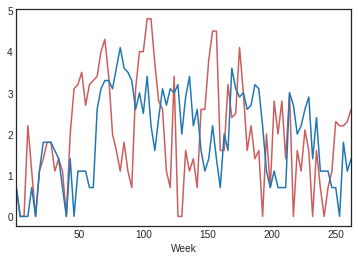

In [13]:
sns.tsplot(df.Patch, time = df.Week, color="indianred");
sns.tsplot(df.NoCut, time = df.Week);

#### Lag one observation 
Tranform nitrate concentration from the previous week so we can see the observation 3 weeks prior. 

In [14]:
df['Patch_lag1'] = df.Patch.shift(1)
df['NoCut_lag1'] = df.NoCut.shift(1)
df.head()

,Week,Patch,NoCut,Patch_lag1,NoCut_lag1
0,1,0.7,0.7,NaN,NaN
1,4,0.0,0.0,0.7,0.7
2,7,0.0,0.0,0.0,0.0
3,10,2.2,0.0,0.0,0.0
4,13,1.1,0.7,2.2,0.0


__Examining Serial Correlation `NoCut`__

Below we plot the observations we just observed vs the observation we obtained last time looking to see what the relationship whould be... "positive correlation"

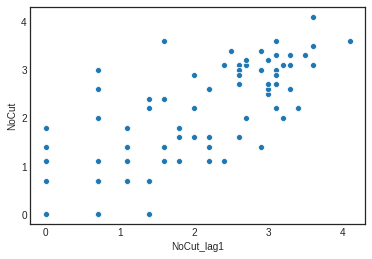

In [15]:
sns.scatterplot(x=df.NoCut_lag1, y=df.NoCut)

Both the graph above and below are showing the same: __Serial Dependence, infering if the previous time we took an observation it was above the mean, then its more likely the observation we take next will also be above the mean__. This is apositive lag, so the observation coorelation will be positive. 

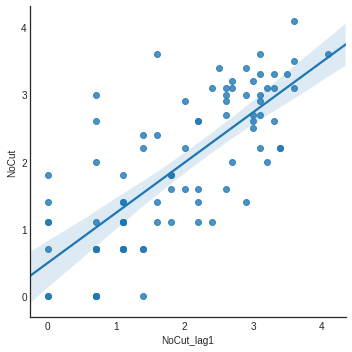

In [17]:
sns.lmplot(x='NoCut_lag1', y='NoCut', data = df)

we have our `NoCult` observations on y-axis and `NoCut_lag` on the x-axis. 

This is a genrally positive slope. More specifically, __the transformed nitrate at a particularlly week is positively correlated with the particular nitrate observation we saw 3 weeks ago.__(or the last time we took an observation).  Therefore, it appears that an observation of the nitrate levels above the mean will tend to be followed by a nitrate above the mean. 

## Estimating Serial Correlation

Below is the sample correlation between the current and previous residual:

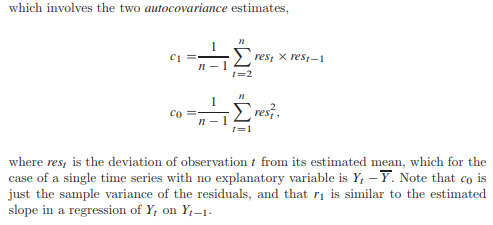

Source: Statistical Sleuth Chapther 15

Below is the residuals we can find with the `acf` __autocorrelation function__ using the `statmodels` library


In [26]:
# https://stackoverflow.com/questions/36038927/whats-the-difference-between-pandas-acf-and-statsmodel-acf
from statsmodels.tsa.stattools import acf, pacf
acf(df.NoCut)

array([ 1.        ,  0.74450971,  0.62539698,  0.49586656,  0.37744234,
        0.26475679,  0.10595869,  0.0703247 , -0.04568919, -0.04574361,
        0.00418204,  0.05448983,  0.12056965,  0.16058713,  0.19133994,
        0.22161398,  0.2241357 ,  0.20099041,  0.1146549 , -0.02048022,
       -0.1182843 , -0.24955411, -0.28829243, -0.34021785, -0.32129049,
       -0.37642895, -0.3478998 , -0.29038078, -0.21791441, -0.10449216,
       -0.02936949,  0.0284559 ,  0.00198447,  0.07652076,  0.08716624,
        0.02295197, -0.04975171, -0.10125985, -0.14436093, -0.23484287,
       -0.22239431])

Our resdiual is the transformed response minus the average watershed. 
Below is a plot of the autocorrelation plot for the `NoCut` using `plot_acf()` function from the `statsmodels` library

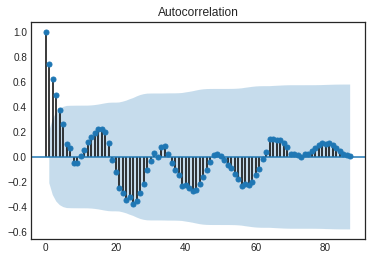

In [19]:
#https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.NoCut);

Seems to be a high correlation between now and the previous observation. 

<Figure size 432x288 with 0 Axes>

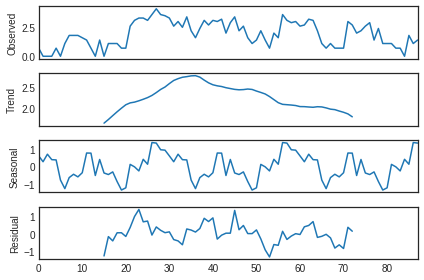

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df.NoCut, model='additive', freq=30)
fig = plt.figure()
fig = decomposition.plot()

### Quantifying How Strong the AutoCorrelation is

Use correlation $r_{1}$ and forumat for the standard error of $r_1$ given by:

$SE_{(r_1)} = \sqrt\frac{1-r_1^2}{n-2}$

Where $r_1$ is the first serial correlation coefficient, where the `_1` describes the order that is used for the __autoregressive model__. Recall, in a time series, we took the lag of the previous observation, hense `AR(1)`. Generally, a __`k` lag__ autocorrelation is the correlation between values that are `k` time periods apart. 

